Импортируем необходимые библиотеки:

In [2]:
import numpy as np
import pandas as pd

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
from tqdm.notebook import tqdm
from pprint import pprint
from statsmodels.stats.weightstats import ztest

In [46]:
import requests
from bs4 import BeautifulSoup
from time import sleep
import bs4
import re
import math
import ast

In [5]:
# для красивых графиков

%config InlineBackend.figure_format = 'retina'

sns.set(style='darkgrid', palette='deep')

plt.rcParams['font.size'] = 16
plt.rcParams['savefig.format'] = 'pdf'

# Шаг 4. Визуализируем данные

Задача: _Сделайте для своих данных разведочный анализ данных, Exploratory Data Analysis (EDA). Выясните, какие в данных есть особенности, визуализируйте их. Ваша задача — откопать в данных интересные закономерности и построить для них красивые, понятные визуализации, на основе которых можно выдвинуть гипотезы и создать для датасета новые переменные._

Подгрузим нашу таблицу df_res, которую мы сохранили в файл 'Interim_Project_5000.csv'.

In [6]:
df_res = pd.read_csv('Interim_Project_5000.csv', index_col=0)
print(df_res.shape)
df_res.head()

(4415, 9)


,artist,country,listeners_lastfm,scrobbles_lastfm,likes,tracks,albums,genres,years_active
0,Coldplay,United Kingdom,5381567.0,360111850.0,1305445,186,60,['rock'],26
1,Radiohead,United Kingdom,4732528.0,499548797.0,387180,200,42,['indie'],38
2,Red Hot Chili Peppers,United States,4620835.0,293784041.0,2155459,266,32,['rock'],41
3,Rihanna,United States,4558193.0,199248986.0,1700983,268,57,"['pop', 'dance', 'rnb']",20
4,Eminem,United States,4517997.0,199507511.0,5278564,396,37,['foreignrap'],35


### Снова работаем с пропусками

Определим функцию, которая поможет выявить пропущенные, нулевые и уникальные значения в каждом столбце данных.

In [9]:
def get_info_about_null_zero_unique(data):
    '''Функция get_info_about_null_zero_unique получает на вход набор данных data и создает DataFrame,
    содержащий информацию о количестве пропущенных значений, нулевых значений и уникальных значений для 
    каждого столбца данных. Кроме того, функция вычисляет процентное соотношение пропущенных, нулевых
    и уникальных значений к общему числу строк в наборе данных.'''
    info = pd.DataFrame({
        'column': data.columns,
        'null': data.isna().sum().values,
        'zero': (data == .0).sum().values,
        'unique': [len(data[col].unique()) for col in data.columns],
    })

    info['% of null'] = info.null / data.shape[0] * 100
    info['% of zero'] = info.zero / data.shape[0] * 100
    info['% of unique'] = info.unique / data.shape[0] * 100
    info['dtype'] = data.dtypes.values
    
    return info

In [8]:
get_info_about_null_zero_unique(df_res)

,column,null,zero,unique,% of null,% of zero,% of unique,dtype
0,artist,0,0,4415,0.0,0.000000,100.000000,object
1,country,0,0,65,0.0,0.000000,1.472254,object
2,listeners_lastfm,0,0,4364,0.0,0.000000,98.844847,float64
3,scrobbles_lastfm,0,0,4386,0.0,0.000000,99.343148,float64
4,likes,0,8,3388,0.0,0.181200,76.738392,int64
5,tracks,0,0,739,0.0,0.000000,16.738392,int64
6,albums,0,95,256,0.0,2.151755,5.798414,int64
7,genres,0,0,1259,0.0,0.000000,28.516421,object
8,years_active,0,103,82,0.0,2.332956,1.857305,int64


Видим, что у 8 исполнителей количество лайков = 0. Выведем этих исполнителей на экран.

In [11]:
df_res[df_res['likes'] == 0]

,artist,country,listeners_lastfm,scrobbles_lastfm,likes,tracks,albums,genres,years_active
1580,Jarkko Eve,Finland,508944.0,3313561.0,0,39,6,"['pop', 'dance', 'rock']",0
2262,Stereo MCs,United Kingdom,373931.0,3207143.0,0,1,0,[],38
2341,喜多郎,Japan,363018.0,5834991.0,0,1,0,[],48
3262,Gerardo Matos Rodríguez,Uruguay,264596.0,8185960.0,0,1,0,[],31
3524,Mia Žnidarič,Slovenia,242243.0,2705004.0,0,60,6,"['jazz', 'pop']",35
3734,Tomahawk,United States,226989.0,6023662.0,0,1,1,[],13
3735,A★Teens,Sweden,226988.0,3113145.0,0,5,3,"['soul', 'pop', 'rnb']",22
4305,Black Sheep,United States,194863.0,1544259.0,0,2,0,[],42


Мы вручную нашли каждого исполнителя с 0 лайков на Яндекс Музыке. Проблема оказалась не в количестве лайков, а в API, который по какой-то причине определил количество нажатий кнопки "Нравится" у исполнителей как 0. Мы решили не тратить время на поиск бага в API Яндекс Музыки и удалили исполнителей с неверными данными. Аналогичная ситуация с исполнителями, у которых отсутствуют альбомы, их мы также удалили из датафрейма.

In [13]:
df_res = df_res[df_res['likes'] != 0]
df_res = df_res[df_res['albums'] != 0]
df_res.head()

,artist,country,listeners_lastfm,scrobbles_lastfm,likes,tracks,albums,genres,years_active
0,Coldplay,United Kingdom,5381567.0,360111850.0,1305445,186,60,['rock'],26
1,Radiohead,United Kingdom,4732528.0,499548797.0,387180,200,42,['indie'],38
2,Red Hot Chili Peppers,United States,4620835.0,293784041.0,2155459,266,32,['rock'],41
3,Rihanna,United States,4558193.0,199248986.0,1700983,268,57,"['pop', 'dance', 'rnb']",20
4,Eminem,United States,4517997.0,199507511.0,5278564,396,37,['foreignrap'],35


Вернёмся к результату исполнения функции get_info_about_null_zero_unique.

In [14]:
get_info_about_null_zero_unique(df_res)

,column,null,zero,unique,% of null,% of zero,% of unique,dtype
0,artist,0,0,4316,0.0,0.000000,100.000000,object
1,country,0,0,62,0.0,0.000000,1.436515,object
2,listeners_lastfm,0,0,4268,0.0,0.000000,98.887859,float64
3,scrobbles_lastfm,0,0,4290,0.0,0.000000,99.397590,float64
4,likes,0,0,3336,0.0,0.000000,77.293791,int64
5,tracks,0,0,739,0.0,0.000000,17.122335,int64
6,albums,0,0,255,0.0,0.000000,5.908248,int64
7,genres,0,0,1245,0.0,0.000000,28.846154,object
8,years_active,0,96,82,0.0,2.224282,1.899907,int64


Теперь обработаем 96 исполнителей, годы активности которых равны = 0.

In [16]:
df_res[df_res['years_active'] == 0].head()

,artist,country,listeners_lastfm,scrobbles_lastfm,likes,tracks,albums,genres,years_active
384,Pendulum,Australia,1347530.0,71232410.0,692683,69,16,['dnb'],0
507,The Kills,United Kingdom,1142592.0,39210777.0,7363,102,23,"['alternative', 'rock']",0
583,Mario,United States,1034711.0,7163539.0,659,114,20,"['rnb', 'soul', 'soundtrack']",0
1021,Crazy Town,United States,712668.0,6273409.0,101337,42,11,['alternative'],0
1103,Donavon Frankenreiter,United States,670798.0,8072859.0,294,128,29,['foreignbard'],0


Вручную нашли в английской википедии несколько артистов, годы активности которых после парсинга оказались равны нулю. 
У этих исполнителей оказался нестандартный вид страницы html, и, чтобы не терять огромное количество времени на дебаж кода по парсингу, мы удалили исполнителей с неправильными данными.

### Попытка перейти к визуализации (работа с отрицательными значениями)

Попробуем построить гистограмму и боксплот для колонки 'years_active'.

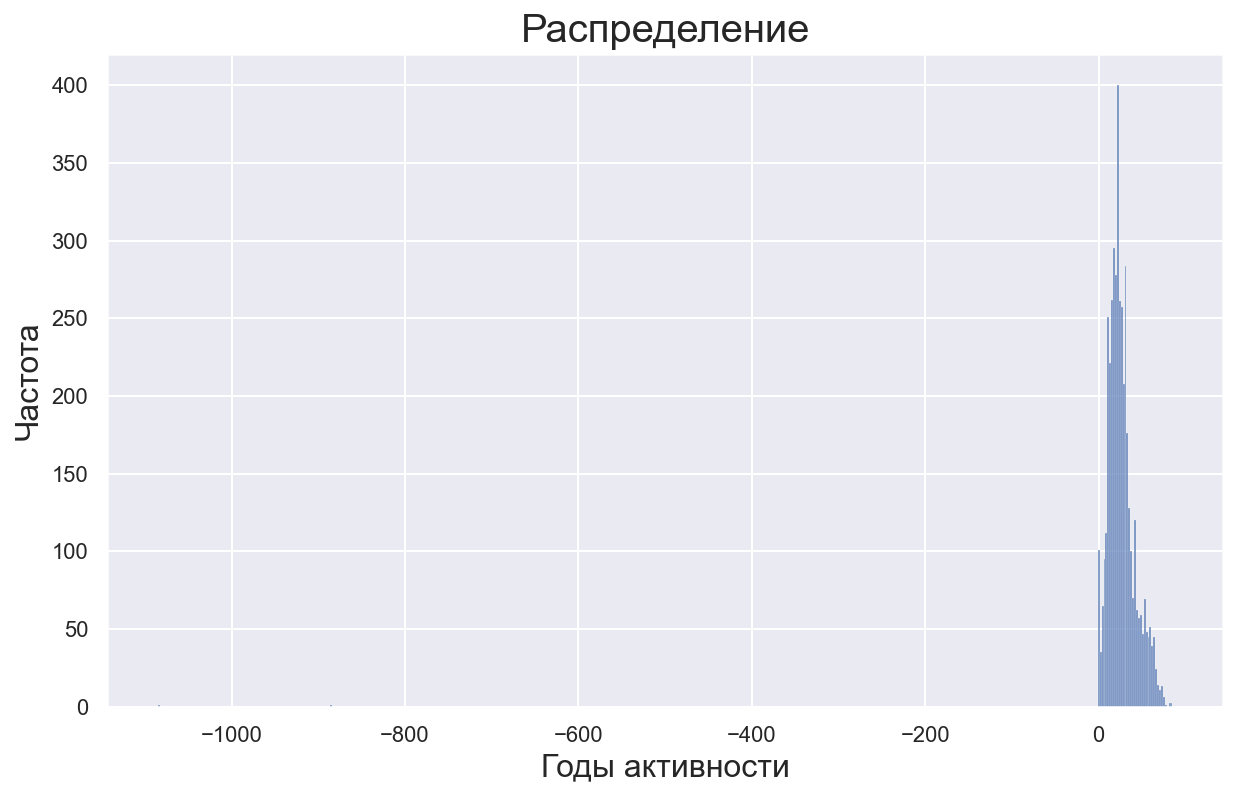

In [17]:
plt.figure(figsize=(10, 6))  

sns.histplot(data=df_res, x='years_active')

plt.title('Распределение', fontsize=20)
plt.xlabel('Годы активности', fontsize=16)
plt.ylabel('Частота', fontsize=16)

plt.show()

Забавно, у нас что, есть отрицательные значения? Посмотрим boxplot.

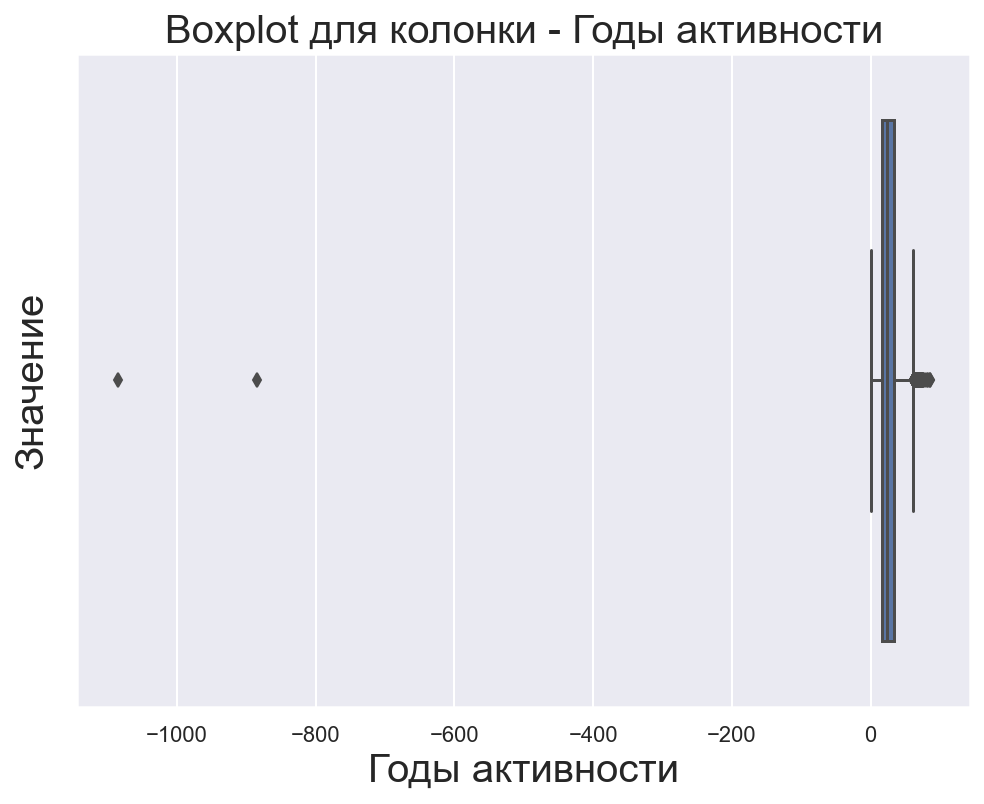

In [18]:
plt.figure(figsize=(8, 6)) 

sns.boxplot(data=df_res, x='years_active')

plt.title('Boxplot для колонки - Годы активности', fontsize=20)
plt.xlabel('Годы активности', fontsize=20)
plt.ylabel('Значение', fontsize=20)

plt.show()


Реально отрицательные значения...

In [19]:
df_res[df_res['years_active'] < 0]

,artist,country,listeners_lastfm,scrobbles_lastfm,likes,tracks,albums,genres,years_active
1324,Cute Is What We Aim For,United States,587490.0,14312429.0,348,26,2,"['rock', 'pop', 'alternative']",-1085
1764,Uffie,United States,464574.0,7559299.0,240,46,11,"['electronics', 'pop', 'dance']",-885


Оказалось, что там на вики этих двух исполнителей были очень специфические данные: 2005–09, 2010–13

Во время парсинга мы не могли предвидеть, что какой-то гений на Википедии будет сокращать года и писать вместо 2009 - 09. Таких значений всего два, поэтому удалим их.

In [20]:
df_res = df_res[df_res['years_active'] > 0]
df_res.head()

,artist,country,listeners_lastfm,scrobbles_lastfm,likes,tracks,albums,genres,years_active
0,Coldplay,United Kingdom,5381567.0,360111850.0,1305445,186,60,['rock'],26
1,Radiohead,United Kingdom,4732528.0,499548797.0,387180,200,42,['indie'],38
2,Red Hot Chili Peppers,United States,4620835.0,293784041.0,2155459,266,32,['rock'],41
3,Rihanna,United States,4558193.0,199248986.0,1700983,268,57,"['pop', 'dance', 'rnb']",20
4,Eminem,United States,4517997.0,199507511.0,5278564,396,37,['foreignrap'],35


Теперь посмотрим на гистограмму и boxplot после удаления строк с отрицательными и нулевыми значениями.

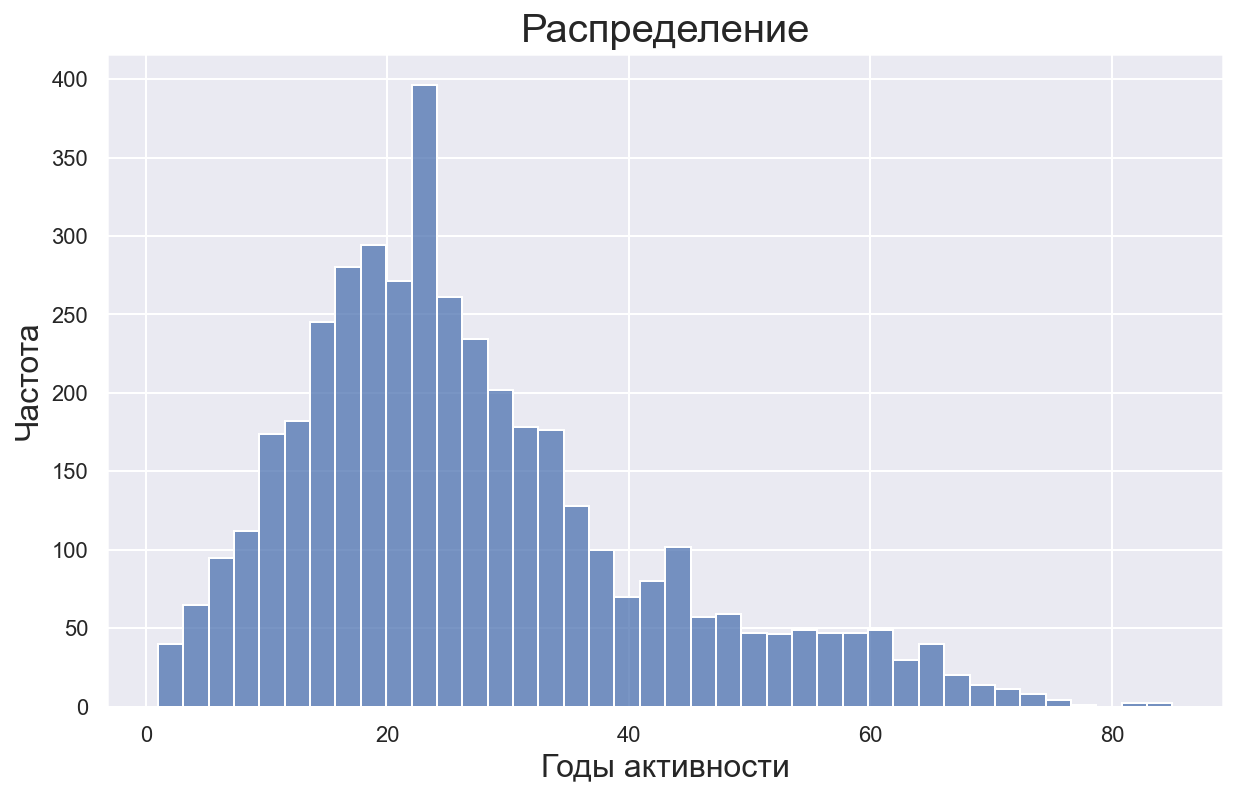

In [21]:
plt.figure(figsize=(10, 6))  

sns.histplot(data=df_res, x='years_active')

plt.title('Распределение', fontsize=20)
plt.xlabel('Годы активности', fontsize=16)
plt.ylabel('Частота', fontsize=16)

plt.show()

Наше распределение похоже на распределение Фишера. Но, кажется, у нас есть выбросы.

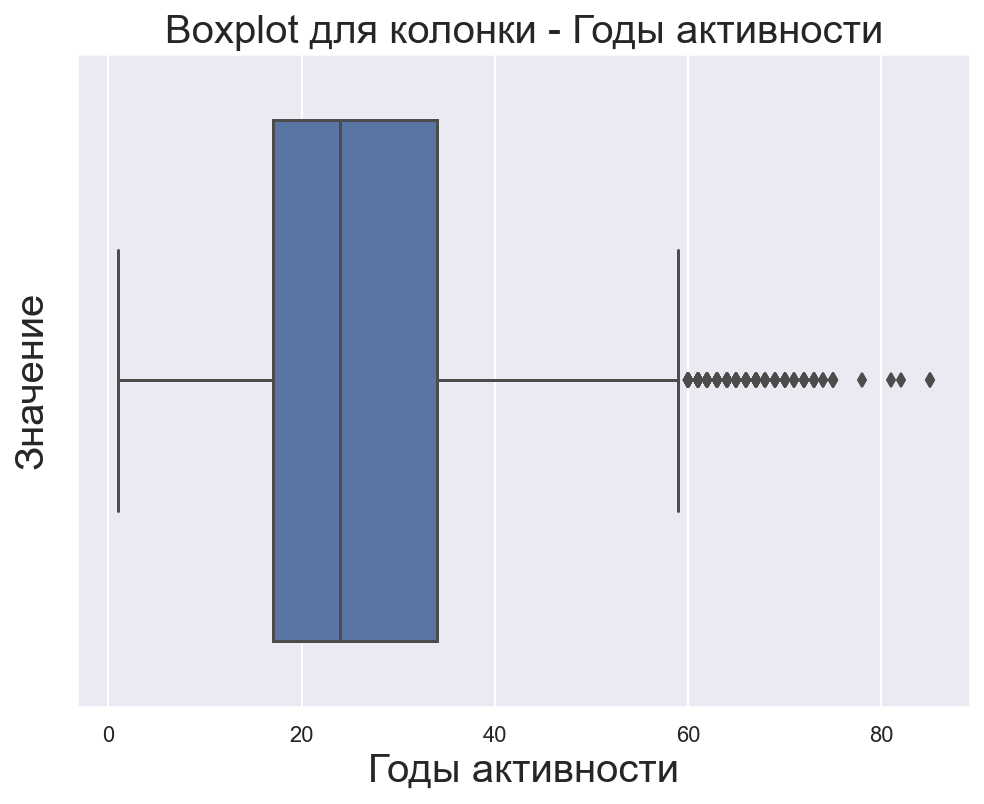

In [22]:
plt.figure(figsize=(8, 6)) 

sns.boxplot(data=df_res, x='years_active')

plt.title('Boxplot для колонки - Годы активности', fontsize=20)
plt.xlabel('Годы активности', fontsize=20)
plt.ylabel('Значение', fontsize=20)

plt.show()


На графиках есть выбросы. Рассматрим значения меньше 60, где начинаются выбросы.

In [23]:
df_res = df_res[df_res['years_active'] < 60]
df_res.shape

(4037, 9)

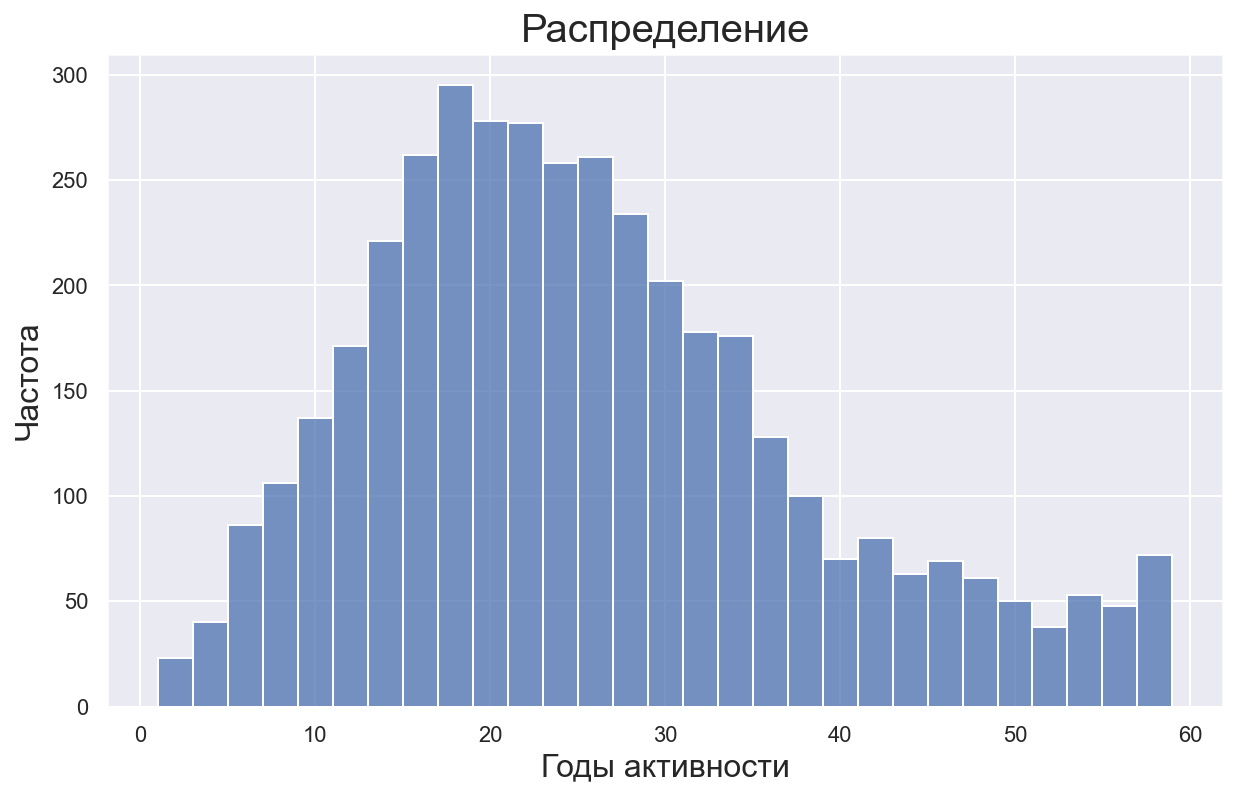

In [24]:
plt.figure(figsize=(10, 6))  

sns.histplot(data=df_res, x='years_active')

plt.title('Распределение', fontsize=20)
plt.xlabel('Годы активности', fontsize=16)
plt.ylabel('Частота', fontsize=16)

plt.show()

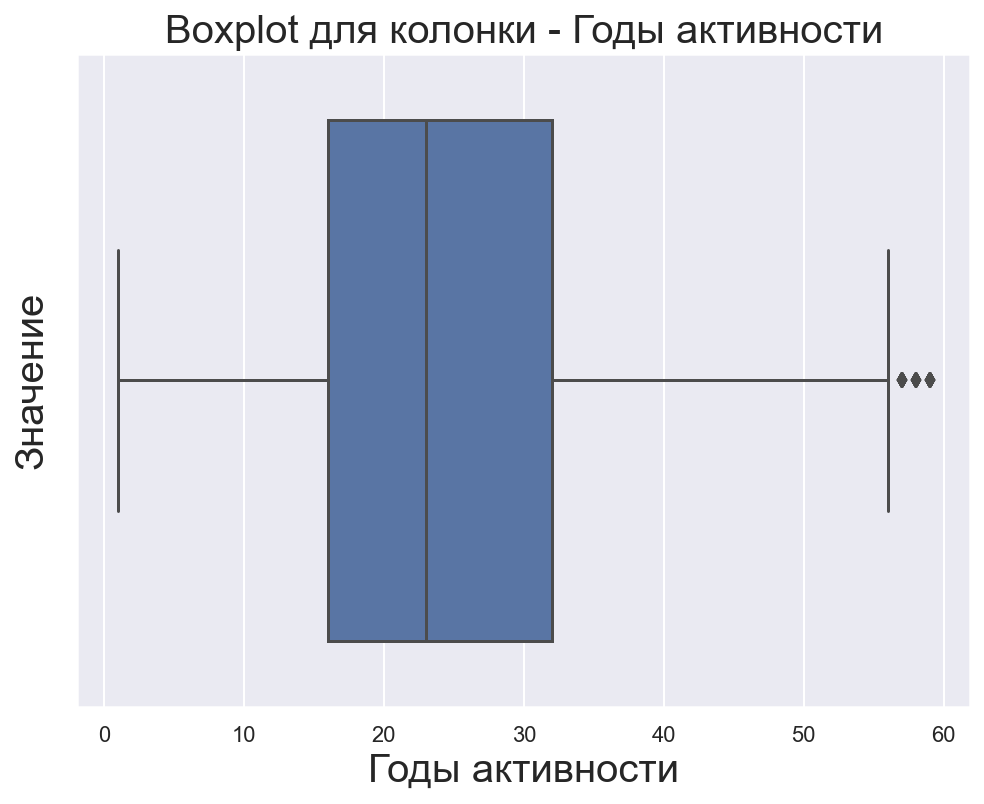

In [25]:
plt.figure(figsize=(8, 6)) 

sns.boxplot(data=df_res, x='years_active')

plt.title('Boxplot для колонки - Годы активности', fontsize=20)
plt.xlabel('Годы активности', fontsize=20)
plt.ylabel('Значение', fontsize=20)

plt.show()

Теперь у нас хорошие графики, юез выбросов и неправильных значений.

## Приступаем к самой визуализации

### Корреляционная матрица

Теперь посмотрим на корреляцию между колонками. Будут ли какие-то зависимости?

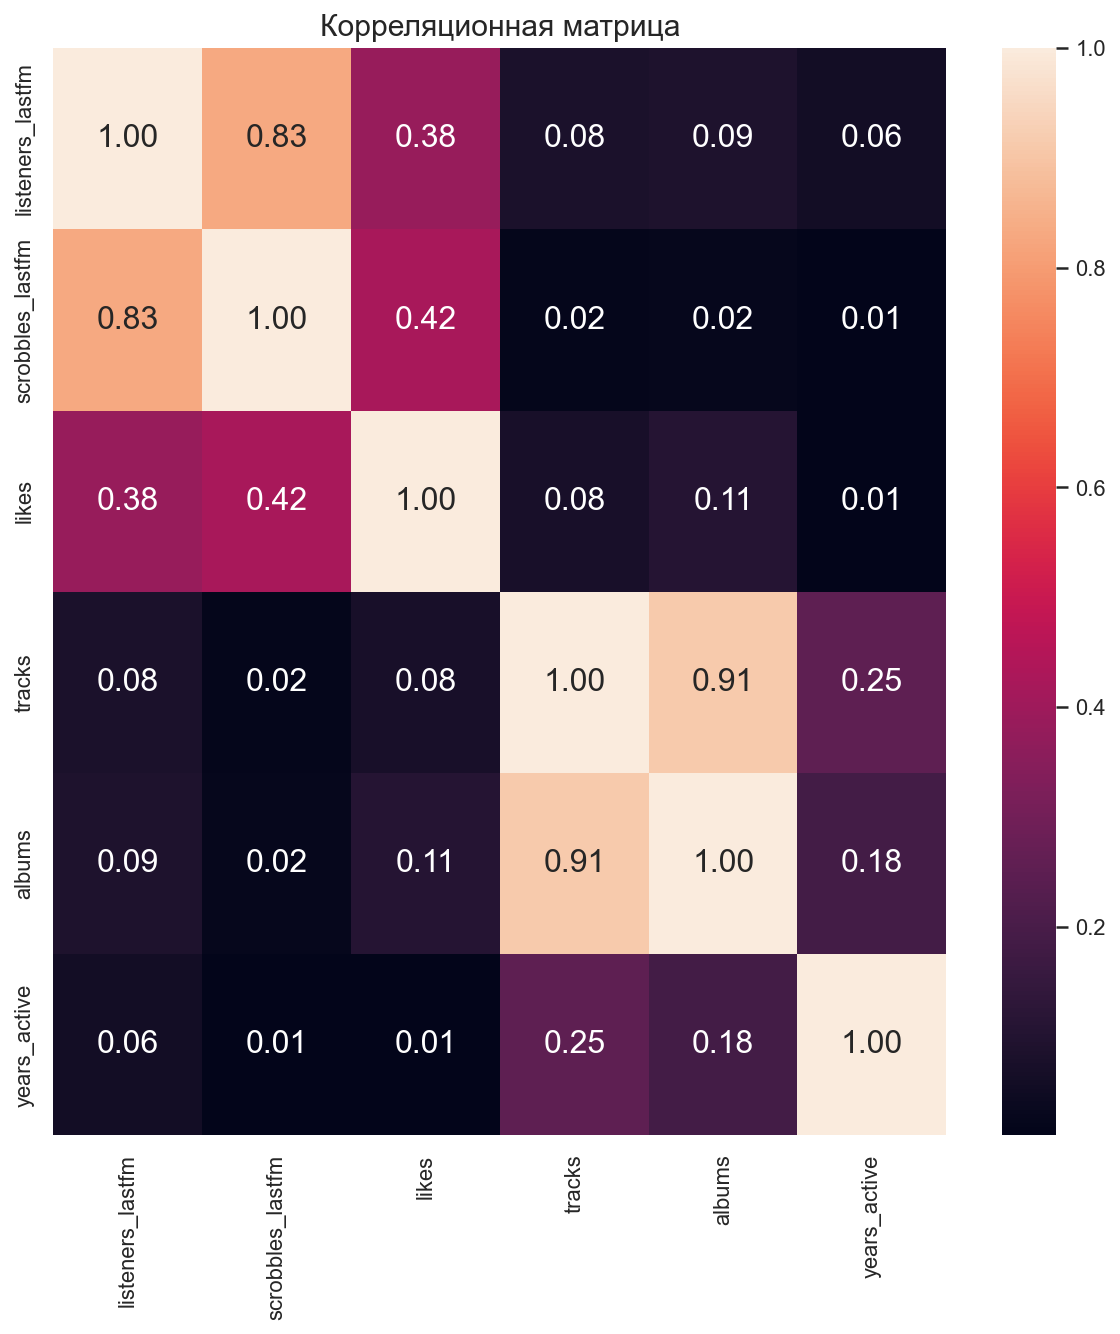

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df_res.corr(), ax=ax, annot=True, fmt=".2f")
ax.set_title('Корреляционная матрица', fontsize=15);

Для анализа корреляций в представленной корреляционной матрице, нужно рассмотреть значения коэффициентов корреляции между переменными. Значения коэффициента корреляции находятся в диапазоне от -1 до 1. Чем ближе значение к 1 или -1, тем сильнее корреляция между переменными. Значение 0 указывает на отсутствие корреляции.

Исходя из предоставленных значений корреляции, можно сделать следующие наблюдения:

Количество слушателей на Last.fm и Количество прослушиваний на Last.fm имеют высокую положительную корреляцию (0.83). Это говорит о том, что большое количество слушателей связано с большим количеством прослушиваний. Это логично, так как чем больше слушателей, тем больше возможных прослушиваний.

Количество прослушиваний на Last.fm и Количество лайков также имеют положительную корреляцию (0.42). Это означает, что треки или альбомы, которые имеют большое количество прослушиваний, часто также получают больше лайков.

Количество треков и Количество альбомов имеют высокую положительную корреляцию (0.91). Это может объясняться тем, что большое количество альбомов часто включает в себя большое количество треков.

Годы активности не имеют значительной корреляции с другими переменными (коэффициенты корреляции близки к 0). Это означает, что количество лет активности группы не сильно влияет на количество слушателей, прослушиваний, лайков или количество треков и альбомов.

#### Теперь построим гистограммы и боксплоты по всем столбцам.

### Изобразим в виде гистограммы столбец со странами. 

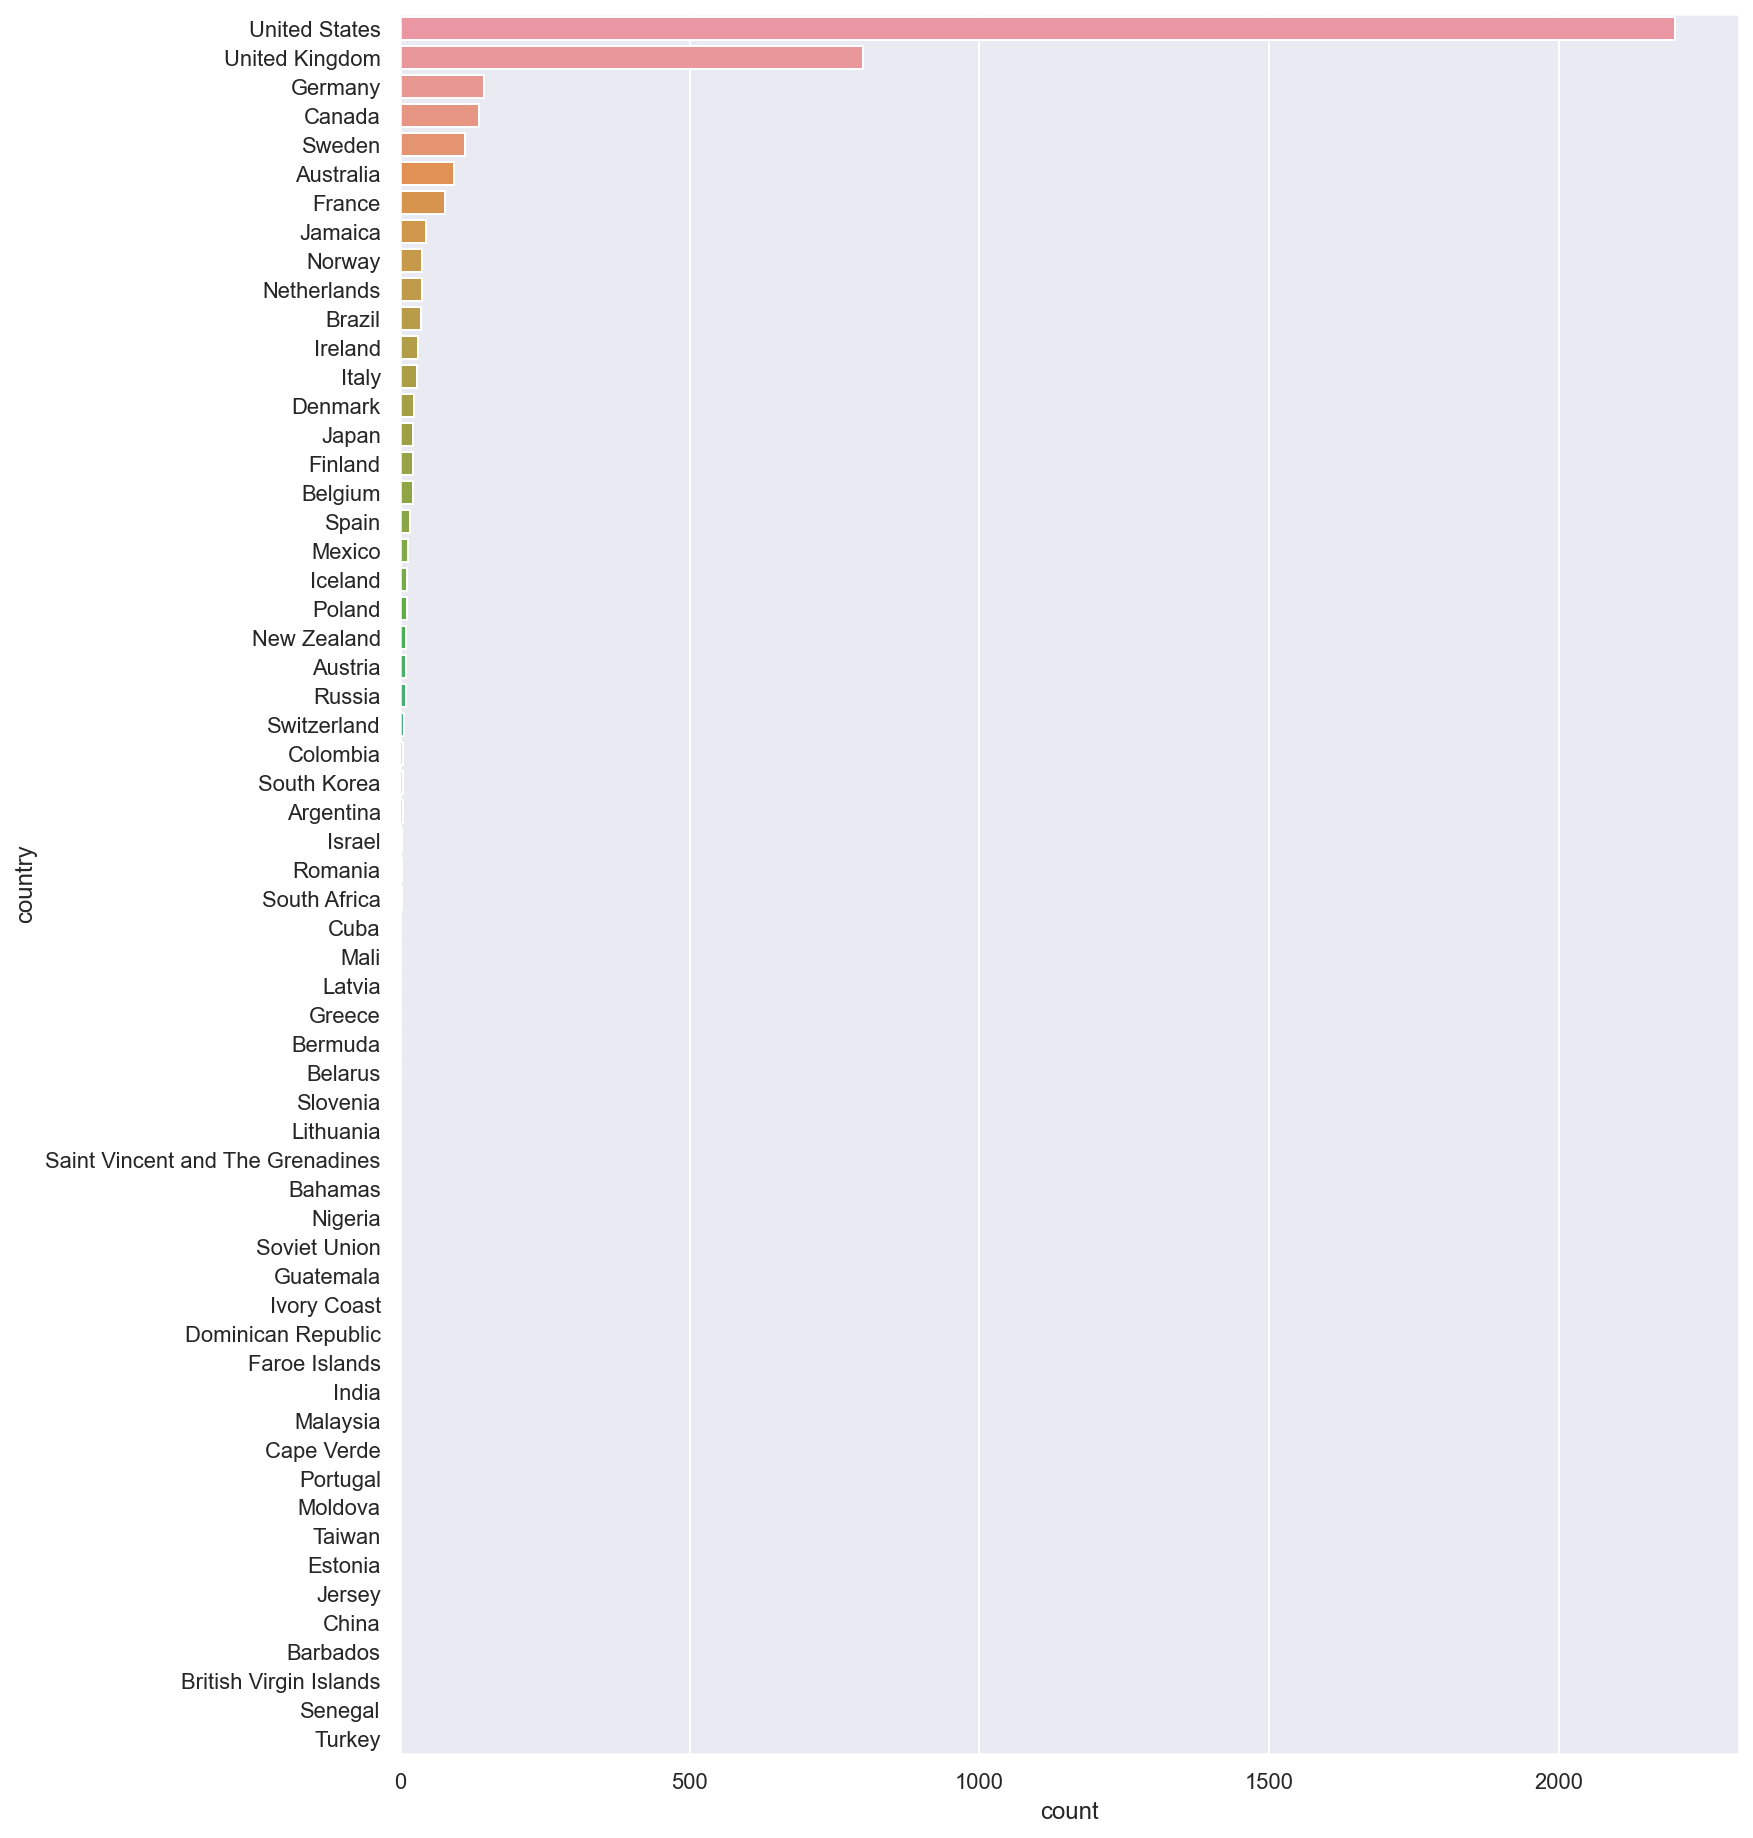

In [27]:
plt.figure(figsize=(12,16))  # Устанавливаем размеры фигуры

sns.countplot(data=df_res, y='country', order=df_res['country'].value_counts().index)
plt.show()  # Отображаем график

Из графика мы видим, что начиная, например, с Аргентины и ниже, чрезвычайно мало исполнителей из этих стран. Поэтому давайте уберем исполнителей из этих стран.

In [28]:
few_albums_cnt = df_res[df_res['country'] == 'Argentina'].shape[0]
albums_cnts = df_res['country'].value_counts()
countries_to_remove = albums_cnts[albums_cnts <= few_albums_cnt].index
countries_to_remove

Index(['Argentina', 'Israel', 'Romania', 'South Africa', 'Cuba', 'Mali',
       'Latvia', 'Greece', 'Bermuda', 'Belarus', 'Slovenia', 'Lithuania',
       'Saint Vincent and The Grenadines', 'Bahamas', 'Nigeria',
       'Soviet Union', 'Guatemala', 'Ivory Coast', 'Dominican Republic',
       'Faroe Islands', 'India', 'Malaysia', 'Cape Verde', 'Portugal',
       'Moldova', 'Taiwan', 'Estonia', 'Jersey', 'China', 'Barbados',
       'British Virgin Islands', 'Senegal', 'Turkey'],
      dtype='object')

In [29]:
df_res = df_res[~df_res['country'].isin(countries_to_remove)]
df_res.shape

(3986, 9)

### Изобразим в виде гистограммы столбец с количеством слушателей на Last.fm. 

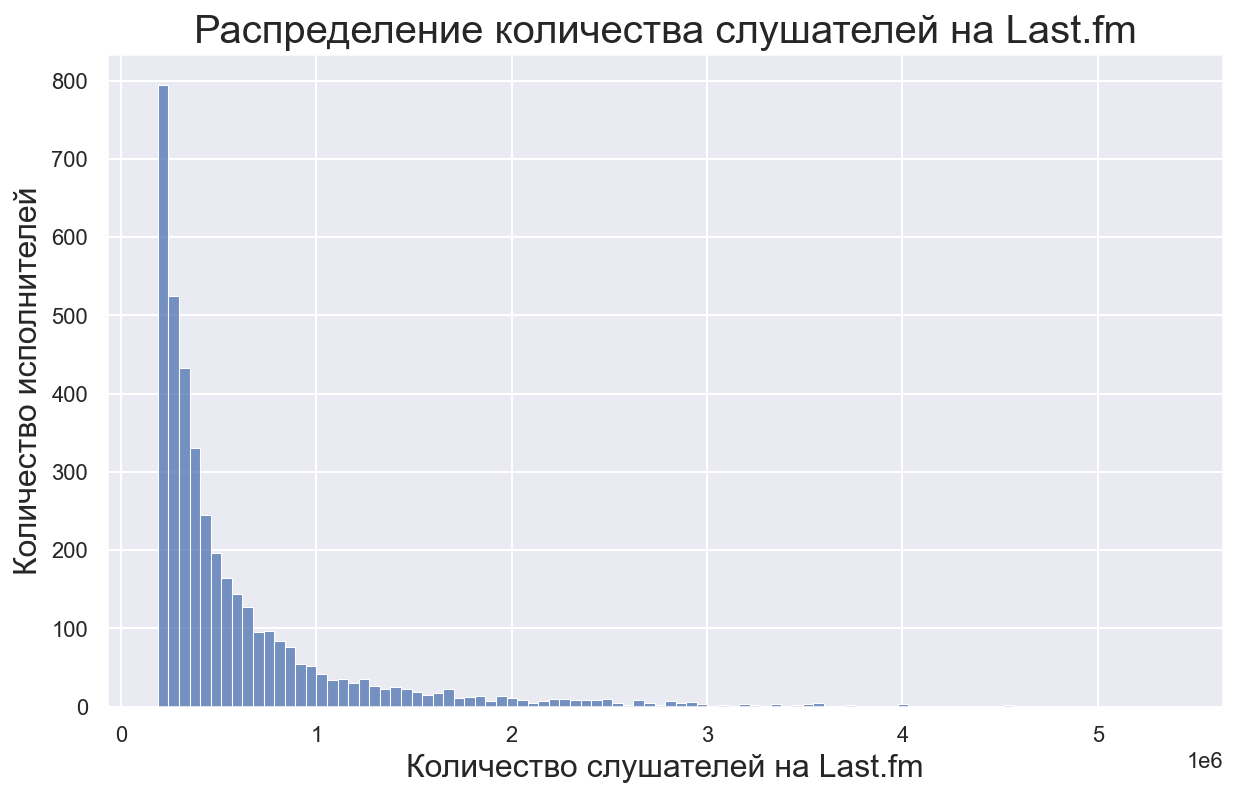

In [30]:
plt.figure(figsize=(10, 6))  

sns.histplot(data=df_res, x='listeners_lastfm')

plt.title('Распределение количества слушателей на Last.fm', fontsize=20)
plt.xlabel('Количество слушателей на Last.fm', fontsize=16)
plt.ylabel('Количество исполнителей', fontsize=16)

plt.show()

Похоже на экспоненциальное распредление. Значит если мы прологарифмируем, то должны получить что-то более интересное.

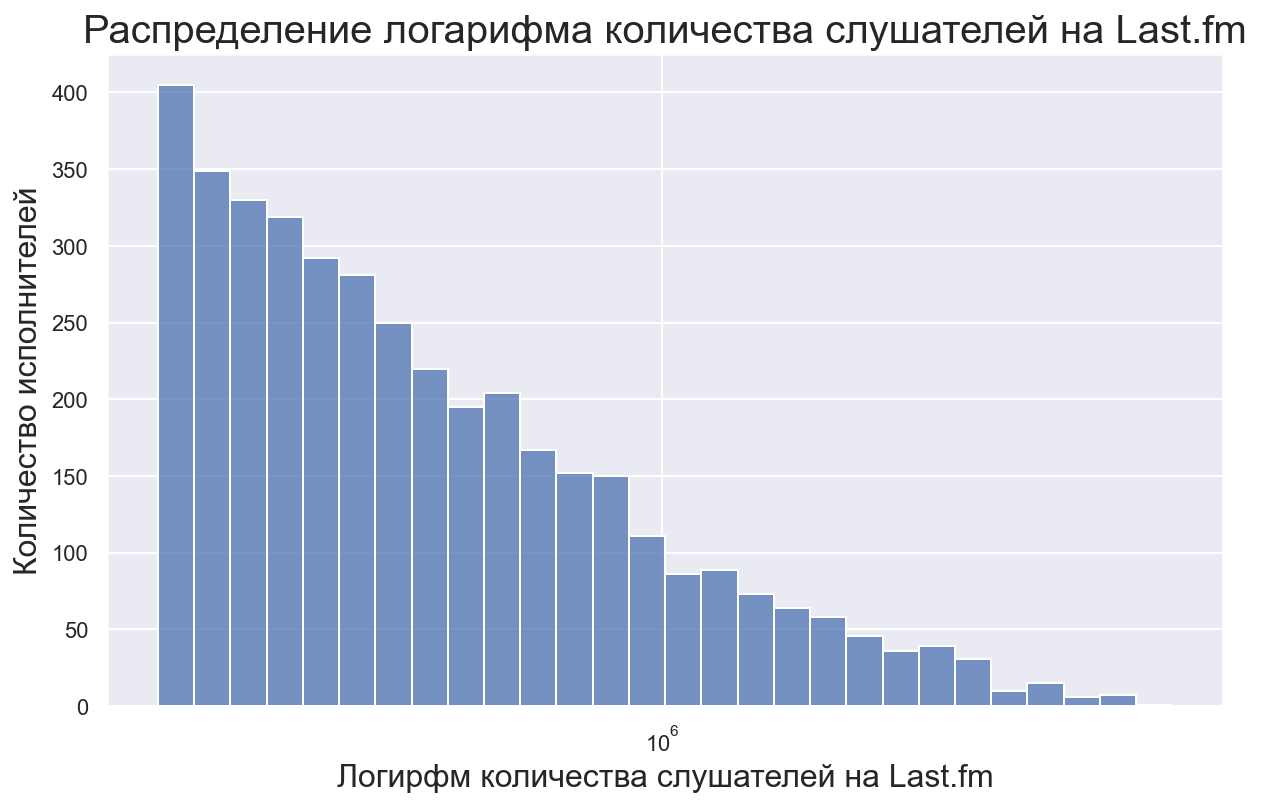

In [31]:
plt.figure(figsize=(10, 6))  

sns.histplot(data=df_res, x='listeners_lastfm', log_scale=True)

plt.title('Распределение логарифма количества слушателей на Last.fm', fontsize=20)
plt.xlabel('Логирфм количества слушателей на Last.fm', fontsize=16)
plt.ylabel('Количество исполнителей', fontsize=16)

plt.show()

Сразу видно улучшение, теперь это похоже на обратно-линейную зависимость.

### Изобразим в виде гистограммы столбец с количеством прослушиваний на Last.fm. 

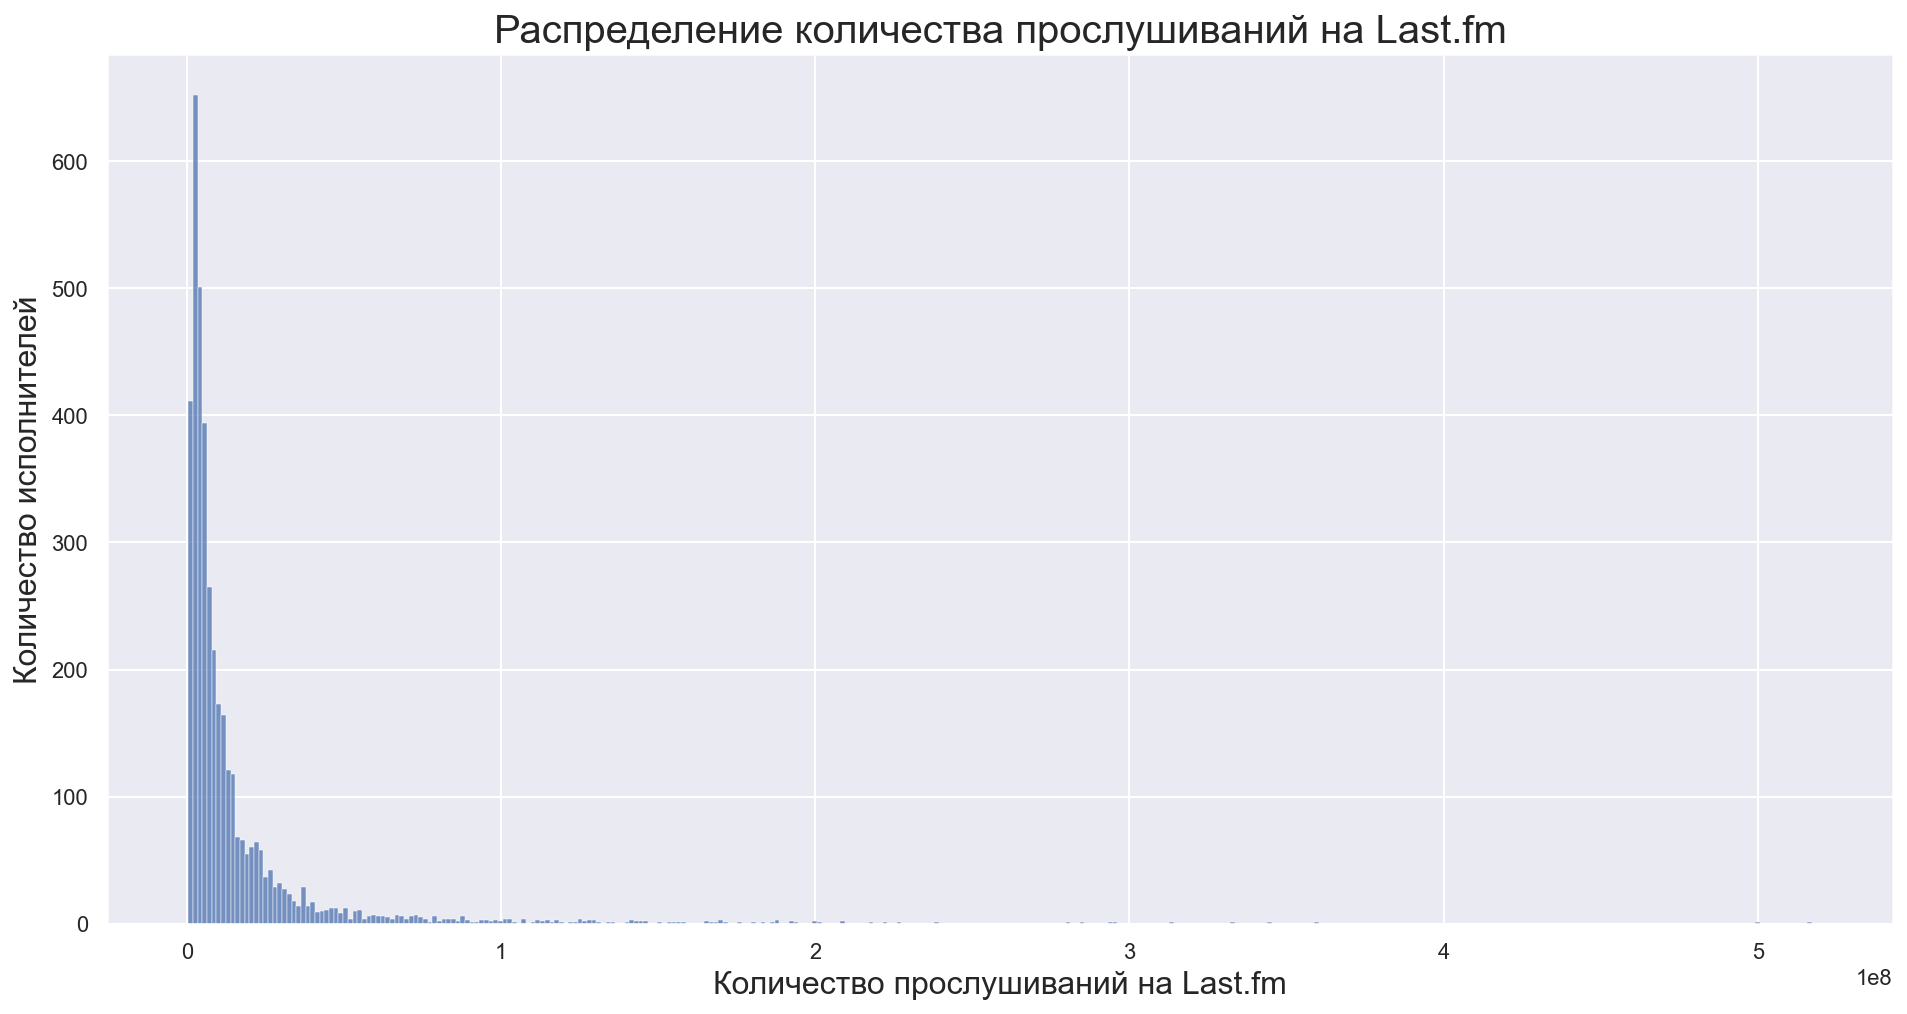

In [32]:
plt.figure(figsize=(16, 8))  

sns.histplot(data=df_res, x='scrobbles_lastfm')

plt.title('Распределение количества прослушиваний на Last.fm', fontsize=20)
plt.xlabel('Количество прослушиваний на Last.fm', fontsize=16)
plt.ylabel('Количество исполнителей', fontsize=16)

plt.show()

Снова что-то похожее на экспоненциальное распределение, так же посмотрим на распределение логарифма от количества прослушиваний.

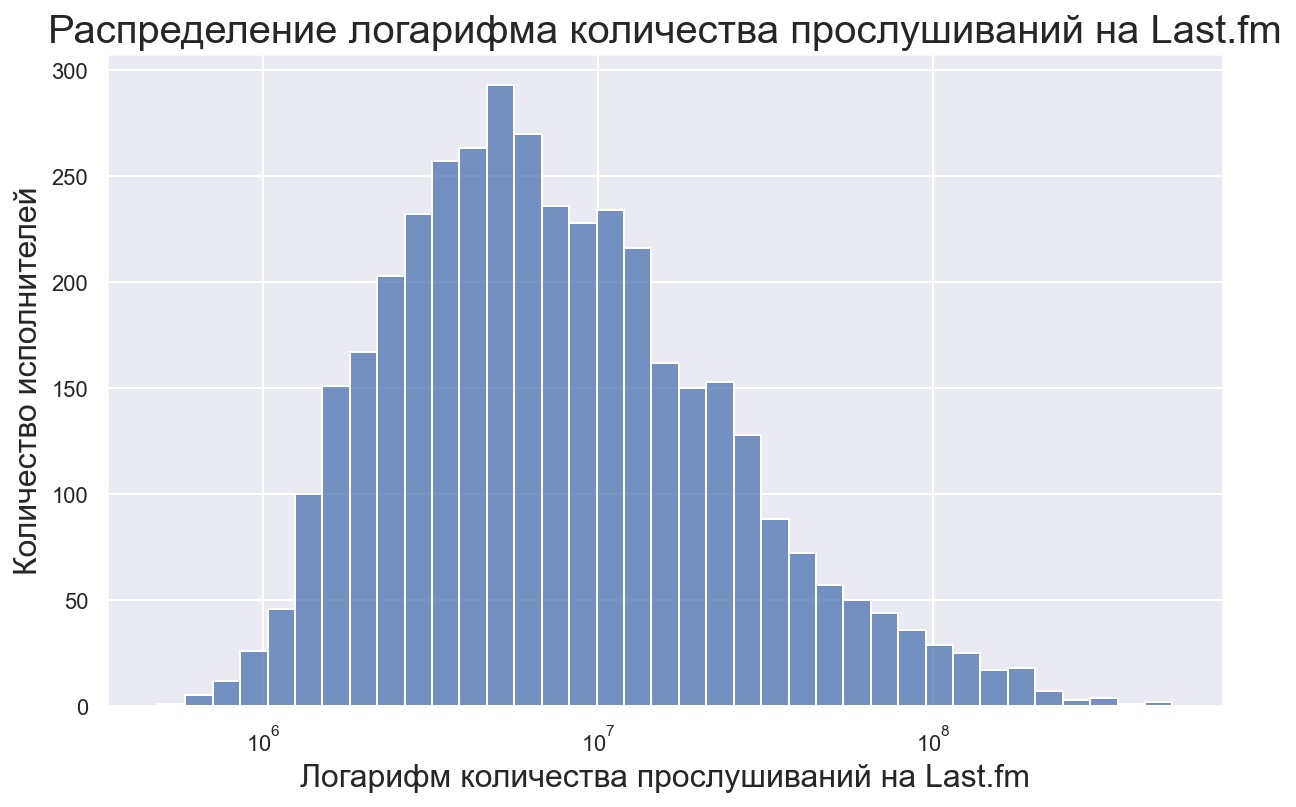

In [34]:
plt.figure(figsize=(10, 6))  

sns.histplot(data=df_res, x='scrobbles_lastfm', log_scale=True)

plt.title('Распределение логарифма количества прослушиваний на Last.fm', fontsize=20)
plt.xlabel('Логарифм количества прослушиваний на Last.fm', fontsize=16)
plt.ylabel('Количество исполнителей', fontsize=16)

plt.show()

А это уже напоминает нормальное распределение или распределение Фишера.

### Изобразим в виде гистограммы столбец с количеством лайков на Яндекс Музыке. 

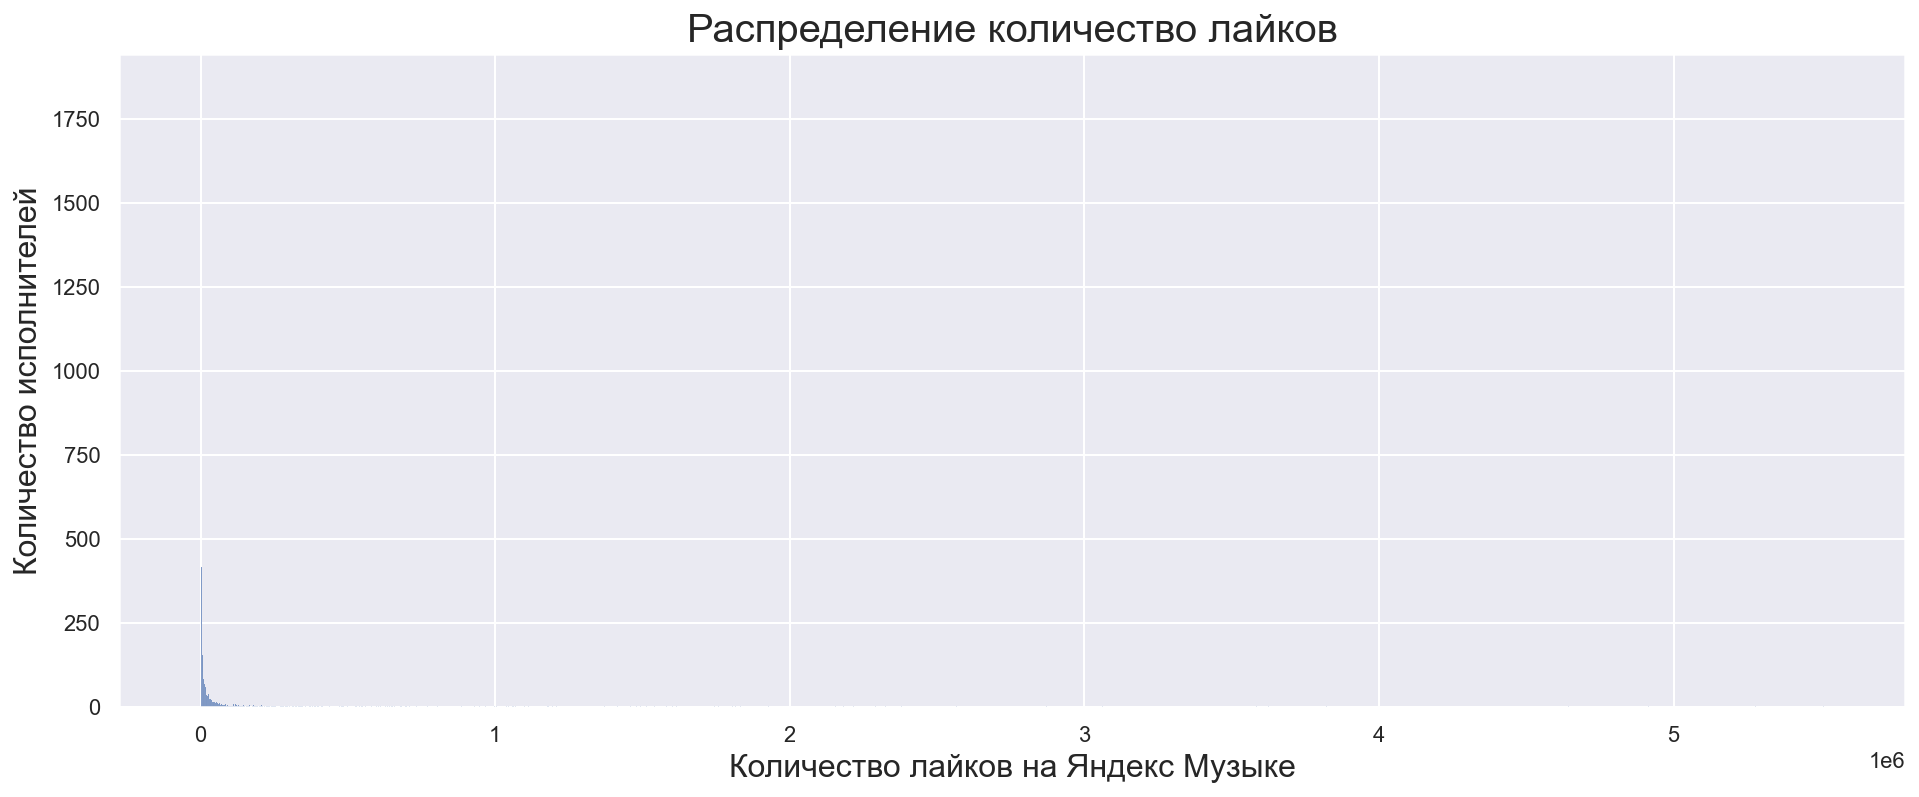

In [35]:
plt.figure(figsize=(16, 6))

sns.histplot(data=df_res, x='likes')

plt.title('Распределение количество лайков', fontsize=20)
plt.xlabel('Количество лайков на Яндекс Музыке', fontsize=16)
plt.ylabel('Количество исполнителей', fontsize=16)

plt.show()

На первый взгляд, это кажется чем-то просто ужасным.... Как будто какие-то дичайшие выбросы. А если мы прологарифмируем...?)

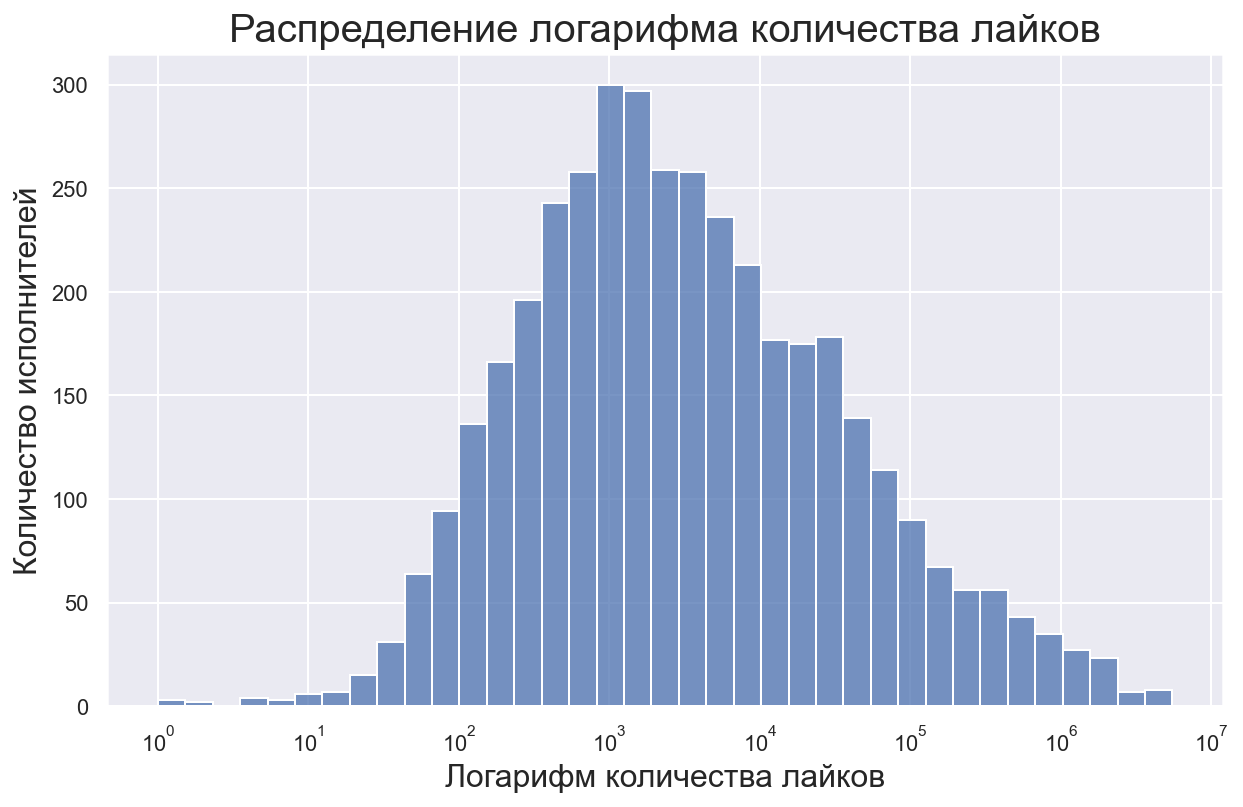

In [36]:
plt.figure(figsize=(10, 6))  

sns.histplot(data=df_res, x='likes', log_scale=True)

plt.title('Распределение логарифма количества лайков', fontsize=20)
plt.xlabel('Логарифм количества лайков', fontsize=16)
plt.ylabel('Количество исполнителей', fontsize=16)

plt.show()

И жизнь заиграла новыми красками.

### Изобразим в виде гистограммы столбец с количество треков на Яндекс Музыке. 

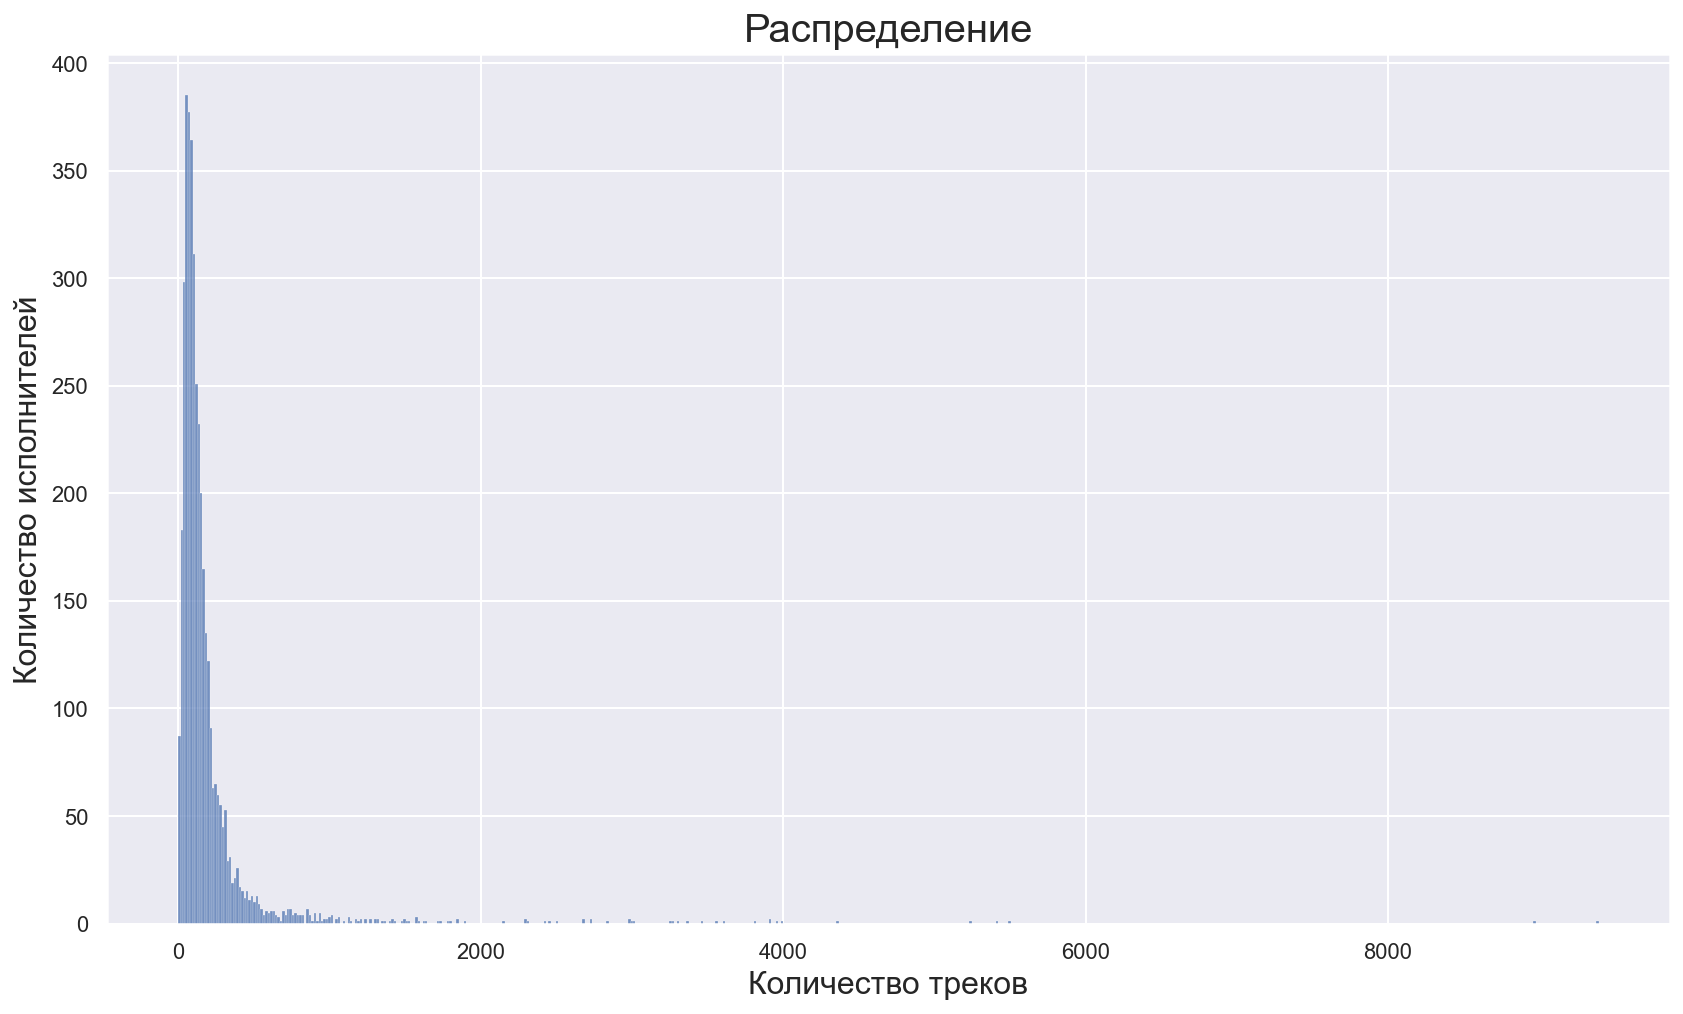

In [37]:
plt.figure(figsize=(14, 8))  

sns.histplot(data=df_res, x='tracks')

plt.title('Распределение', fontsize=20)
plt.xlabel('Количество треков', fontsize=16)
plt.ylabel('Количество исполнителей', fontsize=16)

plt.show()

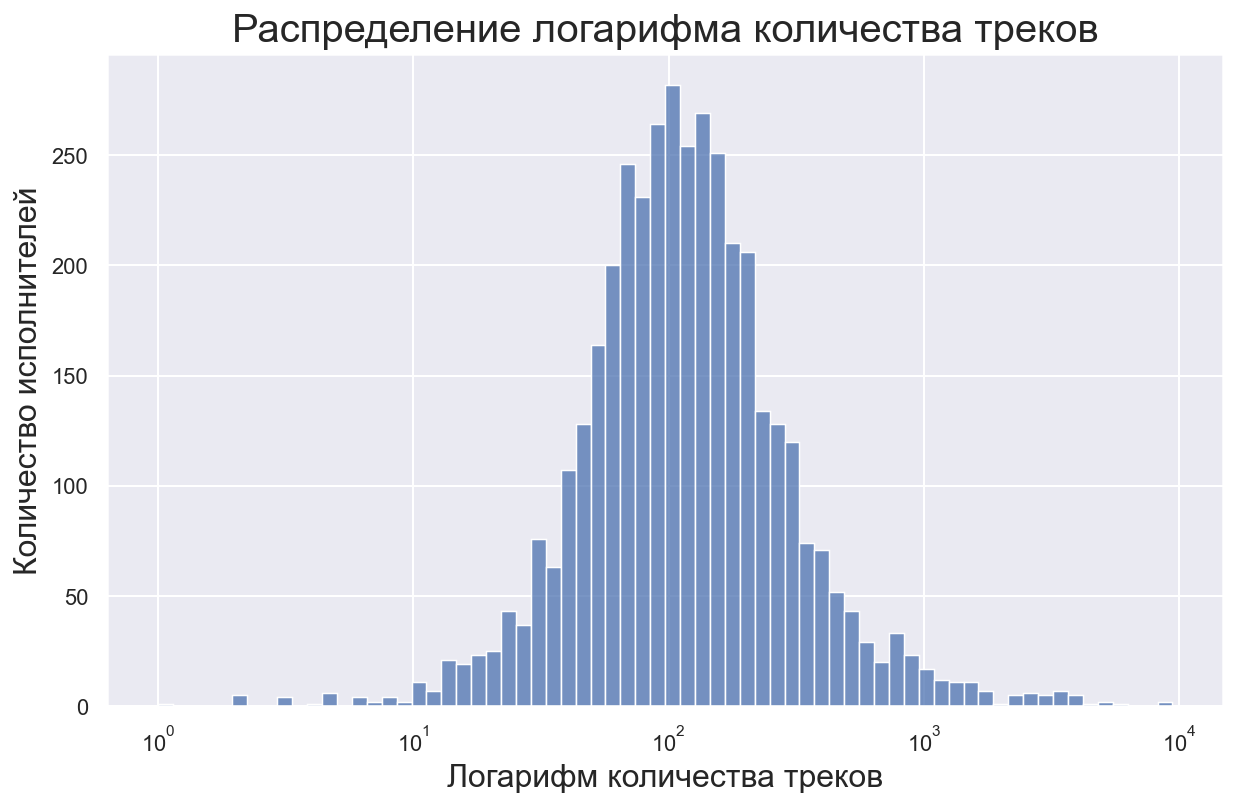

In [38]:
plt.figure(figsize=(10, 6))  

sns.histplot(data=df_res, x='tracks', log_scale=True)

plt.title('Распределение логарифма количества треков', fontsize=20)
plt.xlabel('Логарифм количества треков', fontsize=16)
plt.ylabel('Количество исполнителей', fontsize=16)

plt.show()

После логарифмирования получилось номрмальное распределение.

### Изобразим в виде гистограммы столбец с количеством альбомов 

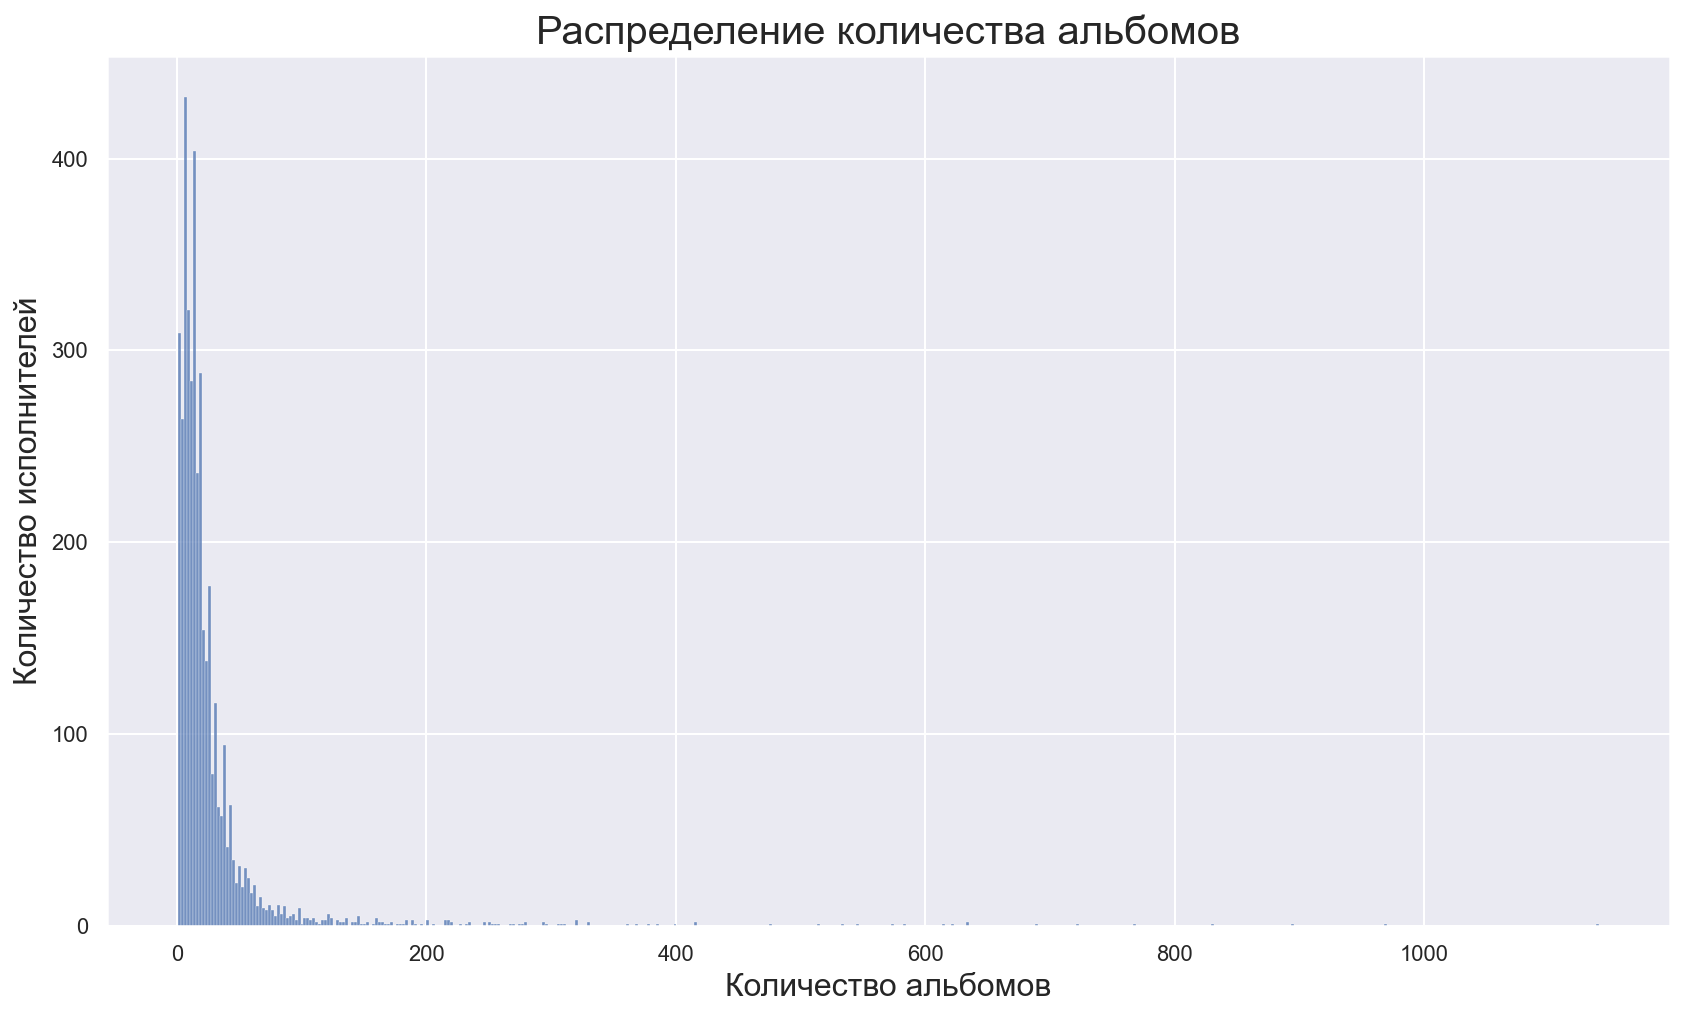

In [39]:
plt.figure(figsize=(14, 8)) 

sns.histplot(data=df_res, x='albums')

plt.title('Распределение количества альбомов', fontsize=20)
plt.xlabel('Количество альбомов', fontsize=16)
plt.ylabel('Количество исполнителей', fontsize=16)

plt.show()

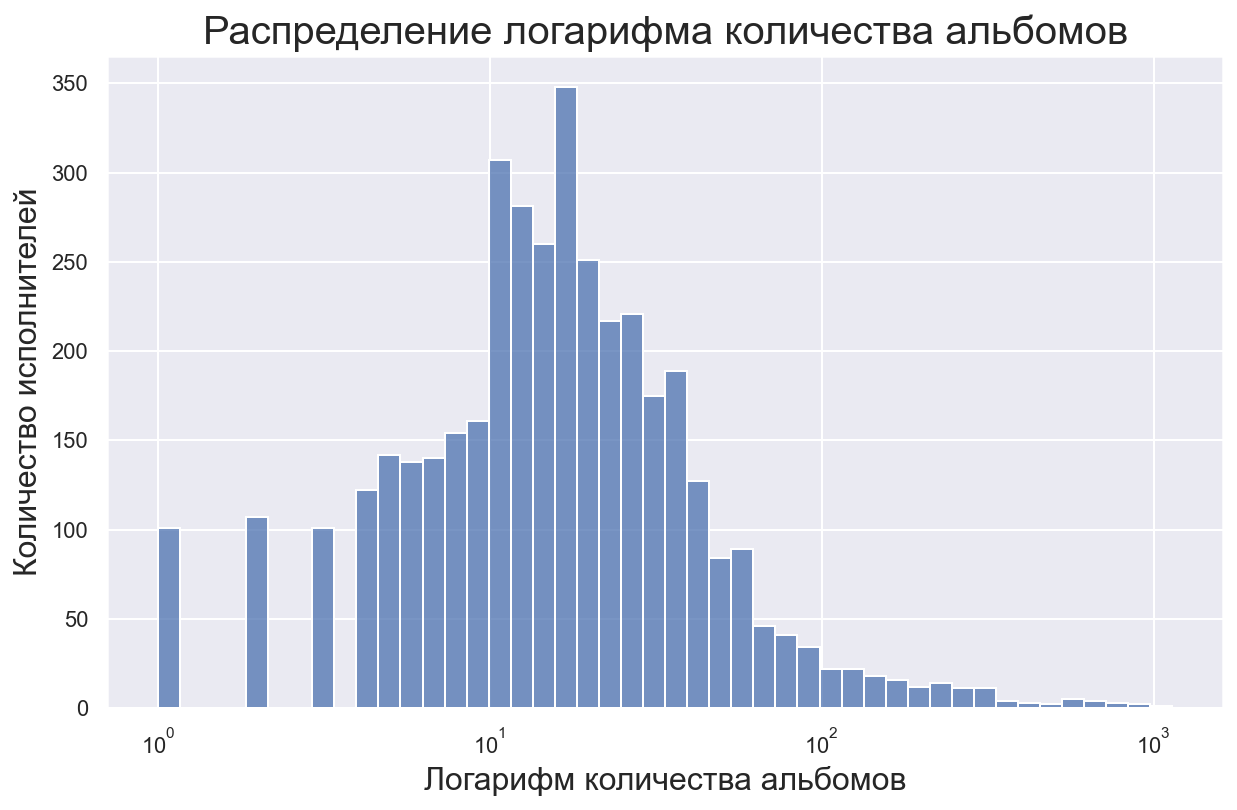

In [41]:
plt.figure(figsize=(10, 6))  

sns.histplot(data=df_res, x='albums', log_scale=True)

plt.title('Распределение логарифма количества альбомов', fontsize=20)
plt.xlabel('Логарифм количества альбомов', fontsize=16)
plt.ylabel('Количество исполнителей', fontsize=16)

plt.show()

Странное поведение в значениях до 10, не совсем поянтно почему так происходит. Видимо, до логарфмирования график был не очень похож на экспоненциальный. Давайте взглянем на исполнителей с <100 альбомами.

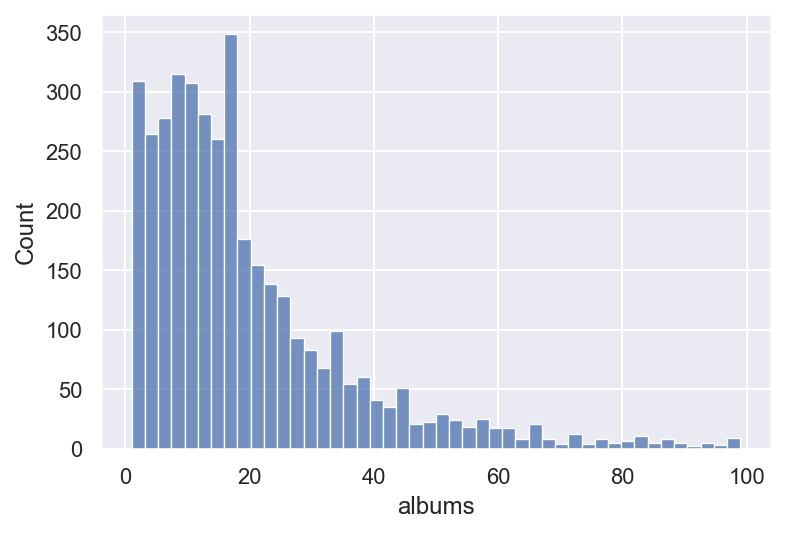

In [43]:
sns.histplot(data=df_res[df_res['albums'] < 100]['albums']);

Что-то более осмысленное, а сколько вообще таких исполнителей?

In [44]:
df_res[df_res['albums'] < 100].shape[0]

3839

Давайте только их и оставим.

In [45]:
df_res = df_res[df_res['albums'] < 100]
df_res.head()

,artist,country,listeners_lastfm,scrobbles_lastfm,likes,tracks,albums,genres,years_active
0,Coldplay,United Kingdom,5381567.0,360111850.0,1305445,186,60,['rock'],26
1,Radiohead,United Kingdom,4732528.0,499548797.0,387180,200,42,['indie'],38
2,Red Hot Chili Peppers,United States,4620835.0,293784041.0,2155459,266,32,['rock'],41
3,Rihanna,United States,4558193.0,199248986.0,1700983,268,57,"['pop', 'dance', 'rnb']",20
4,Eminem,United States,4517997.0,199507511.0,5278564,396,37,['foreignrap'],35


### Запишем данные в результирующий датасет

In [ ]:
df_res.to_csv("eda_data.csv", index=False)

# Шаг 6. Формулимруем и проверяем гипотезу.

На основе визуализации данных мы хотим выдвинуть следующую гипотезу: __отличие среднего кол-ва слушателей у групп из США и Англиии статистически значимо.__

Уровень значимости: $5\%$

$$
\begin{aligned}
& H_0: \mu_{usa} = \mu_{uk} \\
& H_1: \mu_{usa} \neq \mu_{uk}
\end{aligned}
$$

In [70]:
listen_usa = df_res[df_res['country'] == 'United States']['listeners_lastfm']
listen_uk = df_res[df_res['country'] == 'United Kingdom']['listeners_lastfm']

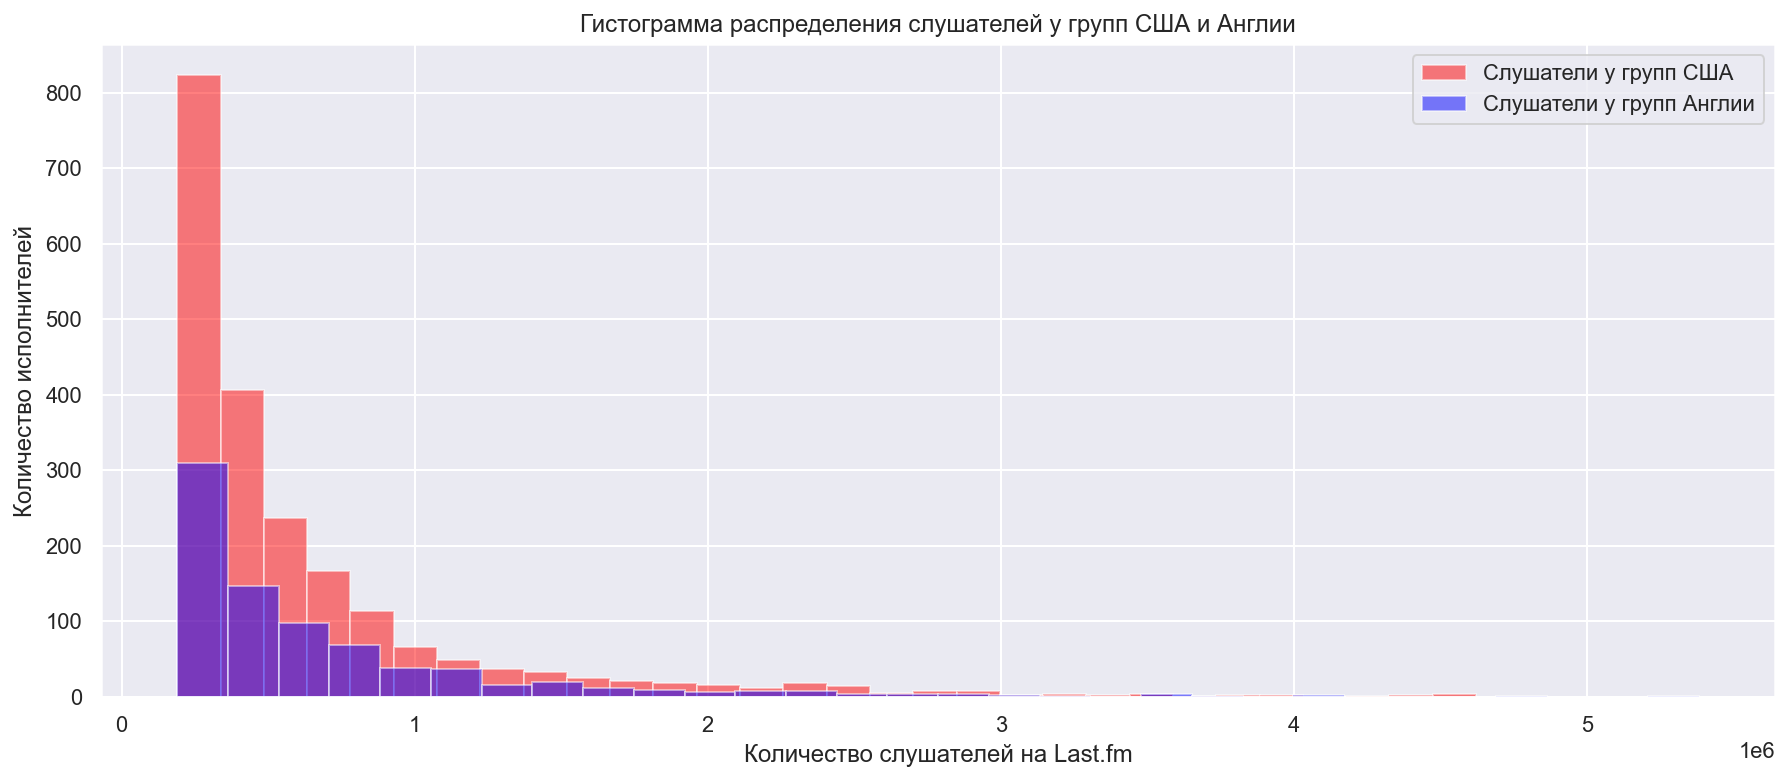

In [76]:
plt.figure(figsize=(15,6))

plt.hist(listen_usa, bins=30, color='red', alpha=0.5, label='Слушатели у групп США')
plt.hist(listen_uk, bins=30, color='blue', alpha=0.5, label='Слушатели у групп Англии')

plt.title('Гистограмма распределения слушателей у групп США и Англии')
plt.xlabel('Количество слушателей на Last.fm')
plt.ylabel('Количество исполнителей')
plt.legend()

plt.show()

Лицезреем экспоненциальное распределение у обеих выборок. С нами отлично отработает z-test, так как данные большие и имеют одинаковое распределение.

In [77]:
p_value = ztest(listen_usa, listen_uk)[1]
alpha = 0.05

if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Среднее количество слушателей у групп из США не равно среднему количеству слушателей у групп из Англии.")
else:
    print("Не отвергаем нулевую гипотезу. Нет достаточных доказательств в пользу того, что среднее количество слушателей у групп из США не равно среднему количеству слушателей у групп из Англии.")

Отвергаем нулевую гипотезу. Среднее количество слушателей у групп из США не равно среднему количеству слушателей у групп из Англии.


Нулевая гипотеза была отвергнута. Значит, отличие среднего кол-ва слушателей у групп из США и Англиии статистически значимо. Но интересно, в пользу какой страны идёт перевес среднего.

In [78]:
if listen_usa.mean() < listen_uk.mean():
    print("Среднее количество слушателей у групп из Англии больше среднего количества слушателей у групп из США.")
else:
    print("Среднее количество слушателей у групп из США больше среднего количества слушателей у групп из Англии.")

Среднее количество слушателей у групп из Англии больше среднего количества слушателей у групп из США.


В пользу Англии. И здесь мы приходим к интересному замечанию - сайт last.fm создан Великобританией и работает на её территории в первую очередь. Соответственно, отвержение нулевой гипотезы и перевес среднего в пользу Англии обоснован не только статистически, но и чисто логически.